# **Chargement / Loading**

<span style="font-size:16px">

Bonjour à tous,

**[FR]**

Pour cette première publication sur Kaggle, nous allons exploiter une petite base de donnée bien connue qui pose des problèmes assez délicats de classifaction.

J'ai choisi cette base de donnée car la data science appliqué à la qualité dans l'industrie m'intérêsse beaucoup. Le fait que j'habite le Beaujolais et que mon frère soit vignerons n'y est pas pour rien non plus. Dans ce contexte je suis tombé sur une études de science des données réalisée par des experts indiens et parue dans la revue "Nature" l'année dernière (article à consulter [ici](https://www.nature.com/articles/s41598-023-44111-9.pdf)). Cet article propose de comparer les principaux algorithmes de classification pour voir leurs résultats. Je propose ici de reproduire ici la même démarche même si je ne choisierais pas toujours les mêmes modèles. Enfin et surtout je souhaite réaliser une classification en trois classes ptôt qu'une classification binaire. En effet, je ne vois pas l'intérêt d'une classification binaire dans un contexte réél : comment un reponsable métier pourrait-il se satisfaire d'une prédiction qui classe les cuvée en "bonne" ou "mauvaise" ? Une classification multiclass permet au moins de distinguer le haut de gamme, du moyen gamme et du bas de gamme. On imagine pour autant que, si la tâche avait été facile, nos data scientist indien l'aurait fait. Nous envisagons donc cette étude à la fois comme une comparaison instructive des modèles de classification et un peu comme "épreuve de bravour" qui nous permettra de dire si un classification multiclass est ici possible oupas.

**[ENG]**

For this first try on kaggle, we will use a well-known DataFrame that raise tricky problems of classification as we are going to see ...

I choose this one because am interested in the application of data science in industry. Moreover i live in a wine area of France calle Beaujolais and my brother is one-maker. I recently came across an article in the journal "Nature" (see [here](https://www.nature.com/articles/s41598-023-44111-9.pdf)) which proposed to use this database to compare different machine learning algorithms. I propose here to do pretty much the same thing with the difference that I want to make a multi-class classification. I also sometimes used slightly different models.

**[Fr/En]**
    
Table des matières / Table of content :
    
* [Préparation des données / preprocessing 3 classes](#1/)
* [Modèle génréral SkLearn / Sklearn general pattern](#2/)
* [KNN](#3/)
* [SVM](#4/)
* [Random Forest](#5/)
* [Grandient Boosting](#6/)
* [Modèle génréral Pytorch / Pytorch general pattern](#7/)
* [Handmade Neural Network](#8/)
* [Tabnet Neural Network](#9/)
* [KNN 2 classes](#10/)
* [Random Forest 2 classes](#11/)
* [Conclusion](#12/)
* [Outils / Tools](#13/)
</span>

In [1]:
# libraries
from time import perf_counter
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, LearningCurveDisplay
from sklearn.preprocessing import RobustScaler

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from imblearn.over_sampling import  RandomOverSampler
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
# from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader

# check random states ....

import torch # keep it to check device
from torch import nn

# Turn on data_chack to display main informations about the data
data_check = False

# Turn on chart_update on to display charts 
chart_update = False

if data_check or chart_update :
    raw_data = pd.read_csv('/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv')

if data_check :
    display("head",raw_data.head(), "describe", raw_data.describe(), "nan values", raw_data.isnull().sum(), "features types", raw_data.info())

<span style="font-size:16px">

**[FR]**

Une base de donnée bien formatée comprennant une distribution continue, sans données manquantes, reliée à un variable de prediction distribuée de manière discrète. Pas de problème majeur.
    
**[ENG]**

Data has no nan. Each features have continue distributions except the target that has discrete distriubtion. No obvius problems.

# **Exploration**

<span>

In [ ]:
def target_distribution(data) :
    # voir si y a pas mieux ...
    target_distribution = pd.DataFrame()
    target_distribution['quality'] = data['quality'].value_counts()
    target_distribution["ratio (%)"] = round(target_distribution['quality'] / target_distribution['quality'].sum() * 100,1)
    print("", "target distribution", "", sep="\n")
    display(target_distribution)

if data_check : target_distribution(raw_data)

<span style="font-size:16px">
    
**[FR]**

La distriubtion de la variable cible n'est pas utilisable en l'état car les effectifs de certaines classes sont trop petites : il va falloir regrouper. Avec deux classes nous aurions facilement un modèle performant. Ce d'autant plus que la suite nous montrera que les classes 7 et 8 de la variable cible serront très difficelement séparables. Cependant une classification binaire ne serrait pas très utile dans une situation réelle. Nous commencerons donc par entrainer un modèle sur trois classes avec premièrement un regroupement des classes 3, 4, 5, qu'on qualifiera de "bas de gamme", deuxièmement une classe 7 telle qu'elle existe qu'on qualifiera de "moyenne gamme", et troisièmement un regroupement des classes 7 et 8 qu'on qualifiera de "haut de gamme". Cela va cependant poser un problème pour cette dernière car son effectif est petit. Avec des effectifs de 200 cette classe cette classe ne représenterait que quelques dizaines de cas dans les échantillions de validation et de test.

**[ENG]**

The numbers of some features are too small to be used as it is: we need to group. A binary classification would be quite easy but not very useful in a real situation. We will therefore start by training a model on three classes with firstly a grouping of classes 3, 4, 5, which will be called "low-end", secondly a class 7 as it exists that will be called "medium-end", and thirdly a grouping of classes 7 and 8 that will be called "high-end". This will however pose a problem for the latter because its workforce is small. With numbers of 200 this class would represent only a few dozen cases in the validation and test samples.

<span>

In [ ]:
if chart_update : plot_distribution(raw_data, "quality") 

<span style="font-size:16px">

**[FR]**

On suspecte ici quelques données aberrantes. Dans une situation réelle il faudrait solliciter une expertise métier pour délimiter les vraies valeurs aberrantes. Après il faudrait choisir un procédé pour réaliser cette tâche. Ici nous allons réaliser un solution automatique basé sur un isolationforest paramétré pour supprimer 2,5 % des données parmis celle qui paraissent les plus aberrantes. Une telle solution présente l"intérêt d'être souple et facilement industrialisable.

**[ENG]**

There is probably outliers. In a real situation, it would be necessary to request a business expertise to delineat the true outliers. Then a process should be chosen to perform this task. Here we will realize an automatic solution based on a isolationforest tuned to remove 2.5% of the most aberant values. This solution has the advantage of being flexible and easily industrialisable.
<span>

In [ ]:
def correlation_matrix(dataframe) :
    matrix = dataframe.corr()
    sns.heatmap(matrix, annot=True, fmt=".1f", linewidth=.5)
    sns.set(rc={"figure.figsize":(4, 3)})
    plt.show()
    
correlation_matrix(raw_data)

<span style="font-size:16px">

**[FR]**

L'études des variables aussi mériterait un travail de documentation et la consultation d'experts métiers afin de comprendre tous les aspects propres à la vignification. Des regroupements de variables sont peut-être possibles, des suppressions aussi. D'un point de vue strictement statistique on observe des correlations (ou correlation inverse) entre certaines variables qui indiquent probablement une colinéarité. Il existent certains modèles d'apprentissage qui n'aiment pas la colinéarité comme les réseaux de neuronnes. C'est pourquoi il faudra verrifier si nos apprentissages ne serraient pas plus performant en réalisant quelques suppressions de variables. D'un autres coté notre base de donnée est déjà suffisament petite comme cela pour que nous ne supprimions pas des variables par défaut. Il faudra voir au cas par cas.

**[ENG]**

The study of the variables also deserves a documentation work and the consultation of professional experts in order to understand all the aspects specific to the wine making. Groupings of variables may be possible, deletions too. From a strictly statistical point of view, correlations (or inverse correlation) are observed between some variables that probably indicate a colinearity. There are some learning models that do not like collinearity like neural networks. This is why it will be necessary to glass if our learnings did not tighten more efficient by making some suppressions of variables. On the other hand, our database is already small enough so that we don’t delete variables by default. It will have to be dealt with on a case-by-case basis.

Corrélation : 
fixed acidity / citric acidity / volatil acidity / PH
free sulfur dioxide / total sulfur dioxide

Relation :
(fixed acidity, citric acidity,  volatil acidity) --> PH
total sulfur dioxide --> (free sulfur dioxide, ??? )

    
# **Préparation des données / preprocessing (3 Classes) <a id="1/"></a>**

<span>

In [2]:
print("", "*"*5 + "preprocessing for 3 classes" + "*"*5, "", sep="\n")


def three_classes(data) :
    main_data = data.copy()
    main_data["quality"] = pd.cut(data["quality"], bins=[0, 5.5, 6.5, 8.5], labels=[0,1,2]).astype(np.int16)
    # targets : class 3, 4 and 5 is 5 ; class 6 is 6 ; class 7 and 8 is 8
    return main_data


def del_outliers(data, outliers_rate) :
    
    prediction = IsolationForest(random_state=69, contamination = outliers_rate).fit_predict(data)
    prediction = pd.DataFrame(prediction, columns=['outliers'])
    plot_data = pd.concat([data, prediction], axis=1)
    plot_data.drop("quality", axis=1, inplace=True)
    data_without_outliers = data[np.where(prediction == 1, True, False)]
    
    print("data shape", data.shape)
    print("data_without_outliers", data_without_outliers.shape)
    if chart_update : plot_distribution(plot_data, "outliers") 
    
    return data_without_outliers


def split(data) :   
    
    print("","spliting data", sep="\n")
    y = data["quality"].to_frame('target')
    X = data.drop("quality", axis=1)
    print("y :", y.shape,"X :", X.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=69)
    print("X_train / X_test / y_train / y_test")
    print(X_train.shape, "/", X_test.shape, "/", y_train.shape, "/", y_test.shape )
    print(".... done", "", sep="\n")
    
    return X_train, X_test, y_train, y_test


def one_hot_encoding(y_train, y_test) :
    
    print("one hot encoding data")
    encoder = OneHotEncoder()
    y_train_encoded = encoder.fit_transform(y_train).toarray()
    y_test_encoded = encoder.transform(y_test).toarray()
    
    print("y_train_encoded.shape / y_test_encoded.shape")
    print(y_train_encoded.shape, "/", y_test_encoded.shape)
    print(".... done")
    
    return y_train_encoded, y_test_encoded


raw_data = pd.read_csv('/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv')

main_data_3c = three_classes(raw_data)

data_without_outliers_3c = del_outliers(main_data_3c, 0.05)

X_train_3c, X_test_3c, y_train_3c, y_test_3c = split(data_without_outliers_3c)

y_train_3c_encoded, y_test_3c_encoded = one_hot_encoding(y_train_3c, y_test_3c)


###################################################################################################################

print("", "*"*5 + "preprocessing for neural network" + "*"*5, "", sep="\n")

class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data  = torch.from_numpy(X_data).float()
        self.y_data  = torch.from_numpy(y_data).float()
        
    def __len__ (self):
        return len(self.X_data)
   
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    

def validation_test_split(X_train, y_train) :
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.30, random_state=69)
    return X_train, X_validation, y_train, y_validation

    
def pd_to_torch(X_train, X_validation, X_test, y_train, y_validation, y_test) :
    
    train_dataset = ClassifierDataset(X_train, y_train)
    val_dataset = ClassifierDataset(X_validation, y_validation)
    test_dataset = ClassifierDataset(X_test, y_test)
    
    return train_dataset, val_dataset, test_dataset


def neural_network_preprocessing(X_train, X_test, y_train, y_test) : 
    
    ### temp : drop ph and free sulfure
    # X_train.drop(["total sulfur dioxide", "pH"], axis=1, inplace=True)
    # X_test.drop(["total sulfur dioxide", "pH"], axis=1, inplace=True)
    
    # make a validation set
    X_train, X_valid, y_train, y_valid = validation_test_split(X_train, y_train)
    
    # scaling 
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test =  scaler.transform(X_test)
    
    # over-sampling
    print("X_train", X_train.shape ,"y_train", y_train.shape)
    # sampler = RandomOverSampler(sampling_strategy = 'minority', random_state = 69)
    sampler = SMOTE(sampling_strategy = 'minority', random_state = 69)
    X_train, y_train = sampler.fit_resample(X_train, y_train)
    print("X_train", X_train.shape ,"y_train", y_train.shape)
    
    # transformation of dataframe into tensor
    train_tensors, validation_tensors, test_tensors = pd_to_torch(X_train, X_valid, X_test, y_train, y_valid, y_test)
    
    return train_tensors, validation_tensors, test_tensors

train_dataset, val_dataset, test_dataset = neural_network_preprocessing(X_train_3c, X_test_3c, y_train_3c_encoded, y_test_3c_encoded)


#######################################################################################

print("", "*"*5 + "preprocessing for 2 classes" + "*"*5, "", sep="\n")

def two_classes(raw_data) :
    main_data = raw_data.copy()
    main_data["quality"] = pd.cut(raw_data["quality"], bins=[0, 5.5, 8.5], labels=[0,1]).astype(np.int16)
    # targets : class 3, 4 and 5 is 5 ; class 6 is 6 ; class 7 and 8 is 8
    
    return main_data

# main_data_2c = two_classes(raw_data)
main_data_2c = two_classes(raw_data)

data_without_outliers_2c = del_outliers(main_data_2c, 0.05)

X_train_2c, X_test_2c, y_train_2c, y_test_2c = split(data_without_outliers_2c)


*****preprocessing for 3 classes*****

data shape (1599, 12)
data_without_outliers (1520, 12)

spliting data
y : (1520, 1) X : (1520, 11)
X_train / X_test / y_train / y_test
(1216, 11) / (304, 11) / (1216, 1) / (304, 1)
.... done

one hot encoding data
y_train_encoded.shape / y_test_encoded.shape
(1216, 3) / (304, 3)
.... done

*****preprocessing for neural network*****

X_train (851, 11) y_train (851, 3)
X_train (1147, 11) y_train (1147, 3)

*****preprocessing for 2 classes*****

data shape (1599, 12)
data_without_outliers (1520, 12)

spliting data
y : (1520, 1) X : (1520, 11)
X_train / X_test / y_train / y_test
(1216, 11) / (304, 11) / (1216, 1) / (304, 1)
.... done



In [ ]:
target_distribution(main_data_3c)    

<span style="font-size:16px">
    
**[FR]**

Comme nous le disions, la classe 7 est trop petite pour réaliser un entrainement correct en l'état. Il faut fair un ré-échantillonnage. Si nous avions assez de données, on ferrait sans le moindre doute un sous-échantillonnage des classes majoritaires. C'est en effet la solution la plus satisfaisante sur le plan méthodologique. On n'a pas d'autre choix ici que de sur-échantillonner les classes minoritaires. Nous utiliserront pour cela une technique de sur-échantillonnage dite naïve. Personellement, j'évite quand il est possible d'utiliser le sur-échantillionnage synthétique car il dépend d'hypothèses méthodologiquement compliquées à justifier. Cependant il permet dans certain cas d'éviter le surapprentissage.

**[ENG]**

As we were saying, class 7 is too small to do a proper training. You have to do a re-sampling. If we had enough data, we would subsample the majority classes. This is the most methodologically satisfactory solution. We have no choice here but to over-sample the minority classes. We will use a so-called naive oversampling technique. Personally, I avoid when it is possible to use synthetic over-sampling because it depends on methodological hypothesis complicated to justify. However, it allows in some cases to avoid overlearning.


# **Modèle général / General pattern <a id="2/"></a>**

**[FR]**

On retrouverra dans le modèle général la façon de procéder pour chaque modèle. Procèdant du plus simple au plus compliqué, on testera successivement : un KNN, un SVM, un RandomForest et un GrandiantBoosting. On s'arrêtera si un modèle donne un résultat suffisant.

**[ENG]**

We will find in the general model how to proceed for each model. Going from the simplest to the most complicated, we will test successively: a KNN, an SVM, a RandomForest and a GrandiantBoosting. We will stop if a model gives a sufficient result.
<span>

In [3]:
print("*"*5,"General Patern for Sklearn","*"*5)

# step 1 : set a pipeline with scaler, sampler, and model and search best parameters in a grid search

def config_pipeline(scaler, sampler, model) :
    
    # set pipeline
    steps = list()
    if scaler != None : steps.append(("scaler", scaler))
    if sampler != None : steps.append(("sampler", sampler))
    if model != None : steps.append(("model", model))
    return Pipeline(steps=steps)


def grid_search(X_train, y_train, scaler, sampler, model, parameters) :
    
    # convert to numpy with the good shape
    y_train = format_target(y_train)

    # set pipeline
    pipeline = config_pipeline(scaler, sampler, model) 
    
    # set grid search
    grid_pipeline = GridSearchCV(pipeline, parameters, cv=5, scoring="balanced_accuracy", n_jobs=-1, verbose=1)
    grid_pipeline.fit(X_train, y_train)

    # research of best parameters
    gridsearch_params = grid_pipeline.best_params_
    sampl_best_params = set_best_parameters(gridsearch_params, "sampler") if sampler else None
    model_best_params = set_best_parameters(gridsearch_params, "model" )
    
    return sampl_best_params, model_best_params


def set_best_parameters(gridsearch_params, tag) :
    
    # recast the parameters
    delete = tag + "__"
    keys = [key.replace(delete,'') for key in list(gridsearch_params.keys()) if tag in key]
    values = [val for key,val in gridsearch_params.items() if tag in key]
    best_params = {key : val for key, val in zip(keys, values)}
    print(f"{tag} best parameters : {best_params}")
    
    return best_params

# step 2 : fit the model with the best parameters and make prediction


def fitting_and_prediction(X_train, y_train, X_test, scaler, sampler, sampl_best_params, model, model_best_params) :
    
    # config sampler and scaler
    if sampler : sampler.set_params(**sampl_best_params)
    model.set_params(**model_best_params)
    
    # fit and predict
    pipeline = config_pipeline(scaler, sampler, model) 
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    classes = list(map(str, pipeline.classes_))
    
    return y_pred, classes

print("... done")

***** General Patern for Sklearn *****
... done


# KNN <a class="anchor" id="3/"></a>


****************************** KNN ******************************

Fitting 5 folds for each of 176 candidates, totalling 880 fits
sampler best parameters : {'random_state': 69, 'sampling_strategy': {2: 300}}
model best parameters : {'metric': 'euclidean', 'n_jobs': -1, 'n_neighbors': 19, 'weights': 'distance'}

Scores :

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       142
           1       0.72      0.56      0.63       131
           2       0.37      0.71      0.48        31

    accuracy                           0.69       304
   macro avg       0.63      0.69      0.64       304
weighted avg       0.72      0.69      0.70       304

Confusion matrix :


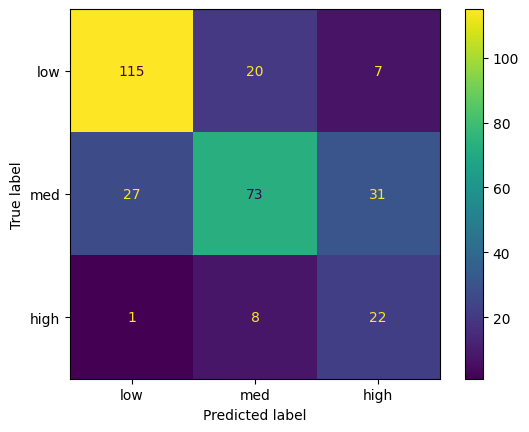


time : 1 minutes


In [6]:
# (with 11 features ; time : 1 minutes / accurracy : 0.69)

def KNN(X_train, X_test, y_train, y_test) :
    
    print("", "*"*30+" KNN "+"*"*30,"",sep="\n")
    start = perf_counter()
    
    parameters = {
        "sampler__sampling_strategy" : [{2: i} for i in [300, 400, 500, 750]],
        "sampler__random_state" : [69],
        "model__n_neighbors" : list(range(10, 21)),
        "model__weights" : ["uniform", "distance"],
        "model__metric" : ["euclidean", "minkowski"],
        "model__n_jobs" : [-1]} 
    
    scaler = RobustScaler()
    sampler = RandomOverSampler()
    model = KNeighborsClassifier()

    sampl_best_params, model_best_params  = grid_search(X_train, y_train, scaler, sampler, model, parameters)
    
    y_pred, classes = fitting_and_prediction(X_train, y_train, X_test, scaler, sampler, sampl_best_params, model, model_best_params)
    
    display_scores(y_test, y_pred, classes)
    
    print("", f"time : {math.ceil((perf_counter() - start)/60)} minutes", sep="\n")
    
KNN(X_train_3c, X_test_3c, y_train_3c, y_test_3c)

# SVM <a class="anchor" id="4/"></a>

In [ ]:
# (with 11 features : time : 2 minutes / balanced accuracy : 0.68)

def simple_svm(X_train, X_test, y_train, y_test) :

    print("", "*"*30+" SVM "+"*"*30,"",sep="\n")
    start = perf_counter()
    
    parameters = {'sampler__sampling_strategy' : [{2: i} for i in [100, 200, 300, 400, 500]],
                  'sampler__random_state' : [69],
                  'model__C': [0.1, 1, 10, 100, 1000], 
                  'model__gamma': [1, 0.1, 0.01], 
                  'model__kernel': ["rbf"], 
                  'model__class_weight' : ["balanced", None],
                  'model__decision_function_shape' : ["ovo", "ovr"]}

    scaler = RobustScaler()
    sampler = RandomOverSampler()
    model = SVC()
    
    sampl_best_params, model_best_params  = grid_search(X_train, y_train, scaler, sampler, model, parameters)

    y_pred, classes = fitting_and_prediction(X_train, y_train, X_test, scaler, sampler, sampl_best_params, model, model_best_params) 
    
    display_scores(y_test, y_pred, classes)
    
    print("", f"time : {math.ceil((perf_counter() - start)/60)} minutes", sep="\n")
    
    return y_pred
    
simple_svm_y_pred = simple_svm(X_train_3c, X_test_3c, y_train_3c, y_test_3c)

In [ ]:
# (with 11 features : time : 9 minutes / accuracy : 0.68)

def ovr_svm(X_train, X_test, raw_y_train, raw_y_test, simple_svm_y_pred) :
    
    print("", " "*33 + "SVM_OVR",sep="\n")
    start = perf_counter()
    
    parameters = {'sampler__sampling_strategy' : [{1: i} for i in [400, 600, 800, 1000, 1200]],
                  'sampler__random_state' : [69],
                  'model__C' : [1, 10, 100,1000], 
                  'model__gamma' : [1, 0.1, 0.01, 0.001], 
                  'model__kernel' : ["rbf"], 
                  'model__class_weight' : [{1: w} for w in [1, 1.5, 2, 4, 8]]}
    
    # init confusion matrix display
    fig, ax = plt.subplots(1, 4, figsize=(16,4))
    fig.suptitle("Confusion Matrix", fontsize=16)
    
    classes = list(zip([0, 1, 2], ['low', 'med', 'high']))
    votes = pd.DataFrame(np.zeros((X_test.shape[0], 3)),columns = [f"class {_class}" for idx, _class in classes])
    
    for idx, class_ in classes :
        
        scaler = RobustScaler()
        sampler = RandomOverSampler()
        model = SVC()
        
        print("" ,"*"*30+f" class {class_ }"+"*"*30, sep="\n")
        
        # binarization of Y-set
        y_train = (raw_y_train == idx).astype(int)
        y_test = (raw_y_test == idx).astype(int)
        
        # fitting 
        sampl_best_params, model_best_params  = grid_search(X_train, y_train, scaler, sampler, model, parameters)
        y_pred, classes = fitting_and_prediction(X_train, y_train, X_test, scaler, sampler, sampl_best_params, model, model_best_params) 
        
        # confusion matrix
        ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred) , display_labels = ['One','Rest']).plot(ax=ax[idx]) 
        ax[idx].set_title(f"Class {class_}")
        
        
        
        votes[f"class {class_}"] = y_pred * idx

    # computation of de votes
    coef = np.count_nonzero(votes, axis=0) / np.count_nonzero(votes)
    numerator = sum([np.dot(coef[num], votes[col]) for num,col in enumerate(votes.columns)])
    denominator = sum([np.dot(coef[num], (votes[col] != 0).astype(int)) for num, col in enumerate(votes.columns)])
    votes["result"] = np.divide(numerator, denominator)
    votes["result"] = np.nan_to_num(votes["result"])
    votes["result"] = np.round(votes["result"]).astype(int)
    
    # complete the missing datas with the predicitions
    for idx in range(len(votes)) :
        if votes.iloc[idx,3] == 0 : votes.iloc[idx,3] = simple_svm_y_pred[idx]
    
    # confusion_ matrix
    print('')
    y_pred = votes["result"].ravel()
    ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(raw_y_test, y_pred, labels = np.unique(y_pred)),
                           display_labels = np.unique(y_pred)).plot(ax=ax[3])
    ax[3].set_title("FINAL MODEL")
    plt.show()
    
    print("", "FINAL SCORES :", "", sep="\n")
    print(classification_report(raw_y_test, y_pred, target_names = ['class 5', 'class 6', 'class 7']))
    
    print("", f"time : {math.ceil((perf_counter() - start)/60)} minutes", sep="\n")
    
ovr_svm(X_train_3c, X_test_3c, y_train_3c, y_test_3c, simple_svm_y_pred)

# Random Forest <a class="anchor" id="5/"></a>


******************************Random_Forest******************************

Fitting 5 folds for each of 40 candidates, totalling 200 fits
sampler best parameters : {'random_state': 69, 'sampling_strategy': {2: 750}}
model best parameters : {'bootstrap': True, 'class_weight': None, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 69, 'verbose': 0}

Scores :

              precision    recall  f1-score   support

           0       0.82      0.85      0.84       142
           1       0.73      0.69      0.71       131
           2       0.47      0.52      0.49        31

    accuracy                           0.75       304
   macro avg       0.68      0.69      0.68       304
weighted avg       0.75      0.75      0.75       304

Confusion matrix :


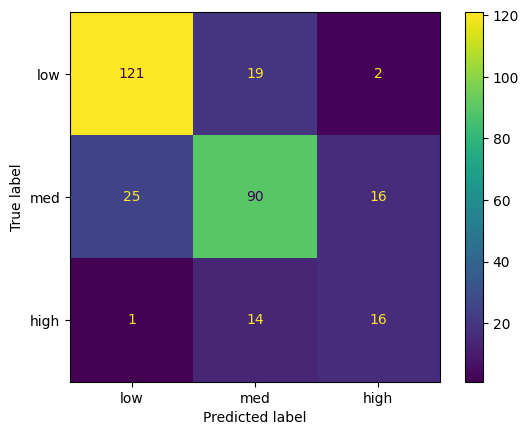


time : 2 minutes


In [8]:
# (with 11 features : time : 2 minutes /  accuracy : 0.75)

def random_forest_for_three_classes(X_train, X_test, y_train, y_test) :
    
    print("", "*"*30 + "Random_Forest" + "*"*30,"",sep="\n")
    start = perf_counter()
    
    parameters = {"sampler__sampling_strategy" : [{2: i} for i in [300, 400, 500, 750]],
                  "sampler__random_state" : [69],
                  "model__n_jobs" : [-1],
                  "model__random_state" : [69],
                  "model__verbose" : [0],
                  "model__class_weight" : ["balanced", None],
                  "model__n_estimators" : [100, 150, 200, 300, 500],
                  "model__bootstrap" : [True]}

    scaler = None
    sampler = RandomOverSampler()
    model = RandomForestClassifier()
    
    sampl_best_params, model_best_params  = grid_search(X_train, y_train, scaler, sampler, model, parameters)
    
    y_pred, classes = fitting_and_prediction(X_train, y_train, X_test, scaler, sampler, sampl_best_params, model, model_best_params)
    
    display_scores(y_test, y_pred, classes)
    
    print("", f"time : {math.ceil((perf_counter() - start)/60)} minutes", sep="\n")
    
random_forest_for_three_classes(X_train_3c, X_test_3c, y_train_3c, y_test_3c)

# Gradient Boosting <a class="anchor" id="6/"></a>


*****Gradient_Boosting

Fitting 5 folds for each of 144 candidates, totalling 720 fits
sampler best parameters : {'random_state': 69, 'sampling_strategy': {2: 400}}
model best parameters : {'device': 'cuda', 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'nthread': 14, 'num_class': 3, 'objective': 'multi:softmax', 'random_state': 69, 'tree_method': 'hist', 'verbosity': 0}

Scores :

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       142
           1       0.66      0.68      0.67       131
           2       0.44      0.48      0.46        31

    accuracy                           0.70       304
   macro avg       0.64      0.64      0.64       304
weighted avg       0.71      0.70      0.70       304

Confusion matrix :


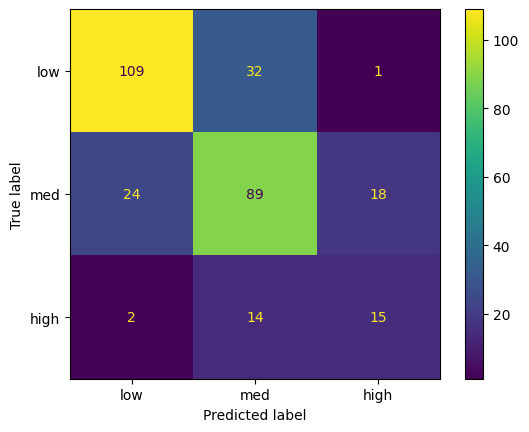

NameError: name 'start' is not defined

In [7]:
# refaire avec un gpu

# (time : 35 minutes / accuracy : 0.7)

def gradient_boosting(X_train, X_test, y_train, y_test) :
        
    print("", "*"*5 + "Gradient_Boosting","",sep="\n")
    start = perf_counter()
    
    parameters = {"sampler__sampling_strategy" : [{2: i} for i in [200, 400, 750]],
                  "sampler__random_state" : [69],
                  "model__random_state" : [69],
                  "model__verbosity" : [0],
                  "model__nthread" : [14],
                  "model__objective" : ["multi:softmax"],
                  "model__num_class" : [3],
                  "model__learning_rate" : [0.4, 0.2, 0.1, 0.01],
                  "model__max_depth" : [5, 6, 7, 8],
                  "model__n_estimators" : [50, 100, 200],
                  "model__device" : ["cuda"],
                  "model__tree_method" : ["hist"],
                 }
    
    from sklearn.preprocessing import LabelEncoder
    y_train = LabelEncoder().fit_transform(y_train)
    y_test = LabelEncoder().fit_transform(y_test)
    
    scaler = None
    sampler = RandomOverSampler()
    model = XGBClassifier()
    
    sampl_best_params, model_best_params  = grid_search(X_train, y_train, scaler, sampler, model, parameters)

    y_pred, classes = fitting_and_prediction(X_train, y_train, X_test, scaler, sampler, sampl_best_params, model, model_best_params)
    
    display_scores(y_test, y_pred, classes)
    
    print("", f"time : {math.ceil((perf_counter() - start)/60)} minutes", sep="\n")
    
gradient_boosting(X_train_3c, X_test_3c, y_train_3c, y_test_3c)

# **Modèle général Pytorch / Pytorch general pattern <a class="anchor" id="7/"></a>**

In [ ]:

def accuracy(y_pred, y_test):
    
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    y_pred_tags = torch.max(y_pred_softmax, dim = 1).indices   
    y_true_tags = torch.max(y_test, dim = 1).indices
    correct_pred = (y_pred_tags == y_true_tags).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc    


def neural_network(train_dataset, val_dataset, test_dataset, model , epochs, batch_size, criterion, optimizer) :
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    torch.manual_seed(69)
    model.to(device)
    model.train()
    
    # Put data to target device
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)
    
    acc_stats = {'train': list(), "val": list()}
    loss_stats = {'train': list(), "val": list()}
    
    for epoch in range(epochs+1):
        
        train_epoch_loss = 0
        train_epoch_acc = 0
        
        for X_train_batch, y_train_batch in train_loader :
            
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            
            ### Training
            optimizer.zero_grad()
            y_train_pred = model(X_train_batch)
            train_loss = criterion(y_train_pred, y_train_batch) #risque_empirique
            train_acc = accuracy(y_train_pred, y_train_batch)
            train_loss.backward()
            optimizer.step()
            
            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()
            
        ### Validation
        with torch.no_grad():
            
            val_epoch_loss = 0 # risque_empirique
            val_epoch_acc = 0
            
            model.eval()

            for X_val_batch, y_val_batch in val_loader:
                
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                y_val_pred = model(X_val_batch)
                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = accuracy(y_val_pred, y_val_batch)
                
                val_epoch_loss += val_loss.item()
                val_epoch_acc += val_acc.item()
        
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader))
        acc_stats['train'].append(train_epoch_acc/len(train_loader))
        acc_stats['val'].append(val_epoch_acc/len(val_loader))
        
        # Accuracy and lost
        if epoch % 200 == 0:
            print(f"Epoch {epoch+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}")
    
    
    y_pred_list = list()
    y_list = list()
    
    ### test
    with torch.no_grad():
        
        model.eval()
        
        for X_batch, y_batch in test_loader :
            
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            
            y_pred_tags = torch.max(y_test_pred, dim = 1).indices
            y_pred_list.append(y_pred_tags.cpu().numpy())
            
            y_tags = torch.max(y_batch, dim = 1).indices
            y_list.append(y_tags.cpu().numpy())
        
        y_pred_list = np.array([i.squeeze().tolist() for i in y_pred_list][0])
        y_list = np.array([i.squeeze().tolist() for i in y_list][0])

    display_scores(y_list, y_pred_list, classes = ["5", "6", "7"])

# Handmade Neural Network <a class="anchor" id="8/"></a>

In [ ]:
## acc : 0.67

start_time = perf_counter()

class MulticlassClassification(nn.Module) :
    
    def __init__(self, num_features, num_hidden_units, num_classes):
        
        super(MulticlassClassification, self).__init__()
        self.input_layer = nn.Linear(num_features, num_hidden_units*12)
        self.hidden_layer_1 = nn.Linear(num_hidden_units*12, num_hidden_units*4)
        self.hidden_layer_2 = nn.Linear(num_hidden_units*4, num_hidden_units*2)
        self.hidden_layer_3 = nn.Linear(num_hidden_units*2, num_hidden_units)
        self.output_layer = nn.Linear(num_hidden_units, num_classes)
        
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p = 0.2)
        
        self.batchnormout = nn.BatchNorm1d(num_hidden_units*12)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_units*4)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_units*2)
        self.batchnorm3 = nn.BatchNorm1d(num_hidden_units)
    
    def forward(self, x):
        
        x = self.input_layer(x)
        x = self.batchnormout(x)
        x = self.activation(x)
        
        x = self.hidden_layer_1(x)
        x = self.batchnorm1(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = self.hidden_layer_2(x)
        x = self.batchnorm2(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = self.hidden_layer_3(x)
        x = self.batchnorm3(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = self.output_layer(x)
        
        return x
    
    
def hand_mad_neural_network(train_dataset, val_dataset, test_dataset) :
    
    # Set hyperparameters
    BATCH_SIZE = 300
    EPOCHS = 2000
    NUM_FEATURES = 11
    NUM_CLASSES = 3
    NUM_HIDDEN_UNIT = 24
    LEARNING_RATE = 1e-4
    
    model = MulticlassClassification(NUM_FEATURES, NUM_HIDDEN_UNIT, NUM_CLASSES)
    # model.to(device)

    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    # optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

    neural_network(train_dataset, val_dataset, test_dataset, model , EPOCHS, BATCH_SIZE, criterion, optimizer) 

hand_mad_neural_network(train_dataset, val_dataset, test_dataset)
    
print("time :", perf_counter() - start_time)

In [ ]:
!pip install pytorch-tabnet
from pytorch_tabnet.pretraining import TabNetPretrainer    
from pytorch_tabnet.tab_model import TabNetClassifier

# TabNet Neural Network <a class="anchor" id="9/"></a>

In [ ]:
def tabnet_neural_network__(X_train, y_train, X_test, y_test) :
    
    X_train = X_train.values
    y_train = y_train.values.ravel()
    X_test = X_test.values
    y_test = y_test.values.ravel()
    X_valid = X_test.copy() 
    y_valid = y_test.copy()
    
    max_epochs = 100
    
    # pretrained model
    unsupervised_model = TabNetPretrainer(optimizer_fn=torch.optim.Adam,
                                          optimizer_params=dict(lr=2e-2),
                                          mask_type='entmax', # "sparsemax",
                                          n_shared_decoder=1, # nb shared glu for decoding
                                          n_indep_decoder=1, # nb independent glu for decoding
                                          verbose=1,
                                         )

    
    unsupervised_model.fit(X_train=X_train,
                           eval_set=[X_valid],
                           max_epochs=max_epochs , patience=5,
                           batch_size=300, virtual_batch_size=128,
                           pretraining_ratio=0.5,
                          )
    
    # model trainning
    clf = TabNetClassifier(optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=2e-2),
                           scheduler_params={"step_size":5, "gamma":0.5},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           # mask_type='sparsemax',
                           verbose=1,
                          )

    clf.fit(X_train=X_train, y_train=y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            eval_name=['train', 'valid'],
            max_epochs=max_epochs , patience=20,
            batch_size=300, virtual_batch_size=128,
            from_unsupervised=unsupervised_model,
           )

    
    preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}
    
    preds_valid = clf.predict_proba(X_valid)
    y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds_valid, axis=1))
    test_acc = accuracy_score(y_pred=y_pred, y_true=y_valid)
    
    y_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
    print(f"FINAL TEST SCORE : {test_acc}")


tabnet_neural_network__(X_train_3c, y_train_3c, X_test_3c, y_test_3c)

# KNN 2 classes <a class="anchor" id="10/"></a>

In [ ]:
def KNN_for_two_classes(X_train, X_test, y_train, y_test) :
    
        
    parameters = { "model__n_neighbors" : list(range(13)),
                   "model__weights" : ["uniform", "distance"],
                   "model__metric" : ["euclidean", "minkowski"],
                   "model__n_jobs" : [-1]} 
    
    scaler = RobustScaler()
    sampler = None
    model = KNeighborsClassifier()

    sampl_best_params, model_best_params  = grid_search(X_train, y_train, scaler, sampler, model, parameters)
    
    y_pred, classes = fitting_and_prediction(X_train, y_train, X_test, scaler, sampler, sampl_best_params, model, model_best_params)
    
    display_scores(y_test, y_pred, classes)
    
KNN_for_two_classes(X_train_2c, X_test_2c, y_train_2c, y_test_2c)

# Random Forest 2 classes <a class="anchor" id="11/"></a>

Fitting 5 folds for each of 6 candidates, totalling 30 fits
model best parameters : {'bootstrap': True, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 69, 'verbose': 0}

Scores :

              precision    recall  f1-score   support

           0       0.73      0.81      0.77       126
           1       0.85      0.79      0.82       178

    accuracy                           0.80       304
   macro avg       0.79      0.80      0.80       304
weighted avg       0.80      0.80      0.80       304

Confusion matrix :


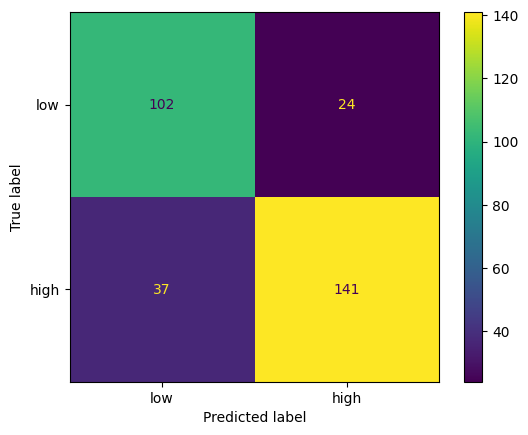

In [10]:
# (time : 3 minutes /  accuracy : 0.80)

def random_forest_for_two_classes(X_train, X_test, y_train, y_test) :
    
    parameters = {"model__n_jobs" : [-1],
                  "model__random_state" : [69],
                  "model__verbose" : [0],
                  "model__n_estimators" : [150, 200, 300, 500, 750, 1000],
                  "model__bootstrap" : [True]}

    scaler = None
    sampler = None
    model = RandomForestClassifier()
    
    sampl_best_params, model_best_params  = grid_search(X_train, y_train, scaler, sampler, model, parameters)
    y_pred, classes = fitting_and_prediction(X_train, y_train, X_test, scaler, sampler, sampl_best_params, model, model_best_params)
    display_scores(y_test, y_pred, classes)


random_forest_for_two_classes(X_train_2c, X_test_2c, y_train_2c, y_test_2c)

<span style="font-size:16px">

# **Conclusion <a class="anchor" id="12/"></a>**
  
| Model              |  Accuracy  |  Low-end  |  Mid-end  |  High-end  |
|:-------------------|:----------:|:---------:|:---------:|:----------:|
| KNN                |0.69        |115        |73         |22          |
| SVM                |0.68        |110        |74         |23          |
| SVM with ovr       |0.68        |99         |98         |19          |
| Random Forest      |0.75        |121        |90         |16          |
| Gradient Boosting  |0.70        |109        |89         |15          |
  
nb : low-end, mid-end, high-end are the true positives predicted by models and displayed on confusion matrixes.

**[FR]**
        
Aucun modèle utilisé seul ne parvient à réaliser une classification multiclasse de manière satisfaisante en l'état. Le problème vient principalement de la sépération entre les cuvées moyenne gamme et bas de gamme.
    
**Avons-nous mal travaillé ?**

En tout cas nous obtenons un accuracy de 0.80 dans notre classification binaire avec un Random Forest contre 0.74 dans notre [étude de référence](https://www.nature.com/articles/s41598-023-44111-9.pdf). Il faut certes lire en détails car nos auteurs indiens annoncent au départ des accuracy trompeurs car provenant des données d'entrainement et non des données de test.

**Pouvons-nous mieux faire ?**

Il y a des améliorations possibles de côté du "features engineering". Nous avons en effet réalisé certaines suppressions de variables qui n'ont pas apporté d'améliorations. Mais nous n'avons pas fait de regroupement car il nous faudrait l'appui d'une expertise métier. De tels regroupements de variables pourraient permettre de diminuer la complexité de la base de donnée et donc l'efficacité de l'apprentissage. Il y a aussi des amélioration possible du côté de la taille de la base ded donnée. L'acqusition de seulement quelques centaines d'exemples améliorerait grandement la puissance de prédiction. Il y a enfin d'autres modèles comme le reseau de neuronne. Les essais  réalisé avec un réseau de neuronne "fait-main" et un reseau de neuronne pré-entrainé (Tabnet) ne nous rends pourtant pas optimiste.

**Comment procéder pour obtenir un modèle industrialisable ?**

Cela dépend essentiellement des contraintes métier. Cependant, en l'absense de contraintes particulières, on peut partir de la classification binaire du Random Forest ci-dessus puis choisir les modèles qui sépare le mieux les cuvées moyen-gamme et les cuvées haut de gamme. Compte tenu des résultats obtenus, il s'agirait probablement d'un SVM ou d'un Random Forest. Pour la mise en production une large part du travail a été réalisé mais il reste à intégrer les étapes de préparation des données dans notre pipeline en créant les classes nécéssaires.

**[ENG]**

No single model achieves a satisfactory multiclass classification as is. The problem comes mainly from the separation between medium and low-end vintages.

**Did we work badly ?**

In any case we obtain an accuracy of 0.80 in our binary classification with a Random Forest against 0.74 in our [baseline study](https://www.nature.com/articles/s41598-023-44111-9.pdf). We must certainly read in detail because our Indian authors initially announce misleading accuracy because coming from training data and not test data.

**Can we do better ?**

There are possible improvements on the "features engineering" side. We have indeed made some deletions of variables that have not made improvements. But we did not group because we would need the support of a business expertise. Such grouping of variables could reduce the complexity of the database and thus the effectiveness of learning. There are also possible improvements in the size of the given ded database. Acquiring only a few hundred examples would greatly improve the power of prediction. There are finally other models such as the neural network. The tests carried out with a "handmade" neural network and a pre-trained neuronne network (Tabnet) do not make us optimistic.

**How to proceed to obtain an industrialisable model ?**

It depends essentially on the business constraints. However, without particular constraints, we can start from the binary classification of the Random Forest above and then choose the models that best separate the medium-range and high-end vintages. Given the results obtained, it would probably be an SVM or a Random Forest. For the production launch a large part of the work has been done but it remains to integrate the stages of data preparation in our pipeline by creating the necessary classes.

# Tools <a class="anchor" id="13/"></a>
</span>

In [9]:
# some usefull tools
    
def plot_distribution(data, hue) :
        # controler la couleur
        g = sns.pairplot(data, hue=hue, palette="hls")
        g.map_lower(sns.kdeplot, cmap="hot",shade=True)
    
def format_target(target) :
    try :
        if target.shape[1] == 1 : target = np.array(target).ravel()
        elif target.shape[1] > 1 : target = np.argmax(target, axis= 1)
    except IndexError: 
        pass
    return target

# display confusion matrix and classification report
def display_scores(y_test, y_pred, classes) :
    
    # check format 
    y_test = format_target(y_test)
    y_pred = format_target(y_pred) 
    
    print("", "Scores :", "", sep="\n")
    print(classification_report(y_test, y_pred, target_names = classes))
    
    print("Confusion matrix :")
    mask = ["low", "med", "high"] if len(classes)==3 else ["low", "high"]
    ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels = mask ).plot()
    plt.show()